In [2]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

# 데이터 불러오기

In [3]:
ds_bo = pd.read_excel('./Downloads/4. 빅데이터분석_실습화일.xlsx',sheet_name='종실1.BOSTON_HOUSING',encoding='CP949')
ds_bo.head()
#관측치 506개, 종속변수 MEDV 1개, 설명변수 13개

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [4]:
ds_bo_y=ds_bo["MEDV"]
ds_bo_x=ds_bo.drop("MEDV", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_bo_y.shape))
print("설명변수 데이터 크기:{}".format(ds_bo_x.shape))

목표변수 데이터 크기:(506,)
설명변수 데이터 크기:(506, 13)


# 과제정의 - 변수 설명, 예측

In [110]:
# 변수 설명, 예측 - 기본적으로 선형 가정, 실제로는 구간마다 증감 폭이 다르고 비선형 예상
# 범죄율 CRIM이 낮을수록
# 주거지 비율 ZN이 높을수록 = ZN은 주거지(25k ft이상의 큰 집의 비율)
# 비소매업 비율(비주거 상업지역? 공업지 비율)INDUS가 낮을수록
# 찰스강이 보일수록, CHAS가 1일수록, 높을수록(보이면1 안보이면0)
# NOX 산화질소농도가 낮을수록?(높을수록 공업지일 확률이 높으나, 차가 많은 번화가도 높을 수 있다.)
# RM(주거당 평균 객실수)가 높을수록
# AGE(노후 건물비율)가 낮을수록? - 번화가의 경우 노후 건물 비율이 높을 수 있음
# DIS(중심지(노동센터)접근거리)가 낮을수록 가까울 수록
# RAD(고속도로 접근 편이성 지수)가 높을수록? - 너무 가까우면 소음, 매연 등의 부작용 
# TAX(재산세율)이 높을수록 
# PTRATIO(마을당 교사비율)이 높을수록
# B(흑인인구비율)이 낮을수록
# LSTAT(저소득층비율)이 낮을수록

# 집값, MEDV(주택가격중앙값)이 높을 것이라 예상

# 분석계획

 구분	분석기법	시나리오/가설
데이터 가져오기 - pd.read_excel
데이터 품질	결측치 처리	
	      이상치 처리	Box Plot으로 이상치 확인
		  이상치의 원인을 파악하고 제거/수정/그대로 반영할 것인가?
그래프, 시각화	
	Box Plot	이상치가 나타나는가?
		변수간 scale 조정이 필요하지는 않은가?
	Scatter	변수간 어떤 산점도 형태를 보이는가? 다중공선성을 내포하지는 않는가?
변환, 변수 파생		설명 변수들이 종속 변수를 얼마나 잘 설명할 수 있는가? 주요한 설명 변수가 있는가?
		영향력이 낮은 변수들의 파생/변환으로 더 설명력을 높일 수 있나?
기술 통계	요약통계:평균	평균으로부터 벗어난 경우 특별한 경향을 보이는가?
	분산	
	빈도분석:최빈값(범주)	최빈값 범주형 변수가 특별한 의미를 가지는가?
추론 통계	회귀분석	주어진 설명변수들로 다중선형회귀분석을 할 수 있는가? H0: beta_i=0
	가설검정	강변 여부에 따라 집값 영향 주는 변수가 다를 것이다
              도심지와의 거리를 구간별로 나누면 영향을 주는 변수가 다를 것이다
다변량 통계	상관관계 분석	설명변수간 어떤 상관관계를 나타내는가? 설명변수의 수를 줄일 수 있는가?

모델 평가	모델 평가 지표	상정한 모델이 얼마나 높은 정확도와 안정성을 보이는가?


# 데이터현황

In [111]:
ds_bo.isnull().sum()
#결측치 없음

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [112]:
ds_bo_describe=ds_bo.describe()
ds_bo_describe.round(3)
#기술통계 - 
#CHAS의 평균이 0.069이므로 대부분이 강과 떨어져 있음
#CRIM의 평균이 낮아 대부분은 범죄율이 낮음

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,22.533,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653
std,9.197,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141
min,5.000,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730
25%,17.025,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.377,6.950
50%,21.200,0.257,0.000,9.690,0.000,0.538,6.209,77.500,3.207,5.000,330.000,19.050,391.440,11.360
75%,25.000,3.677,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955
max,50.000,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970


/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


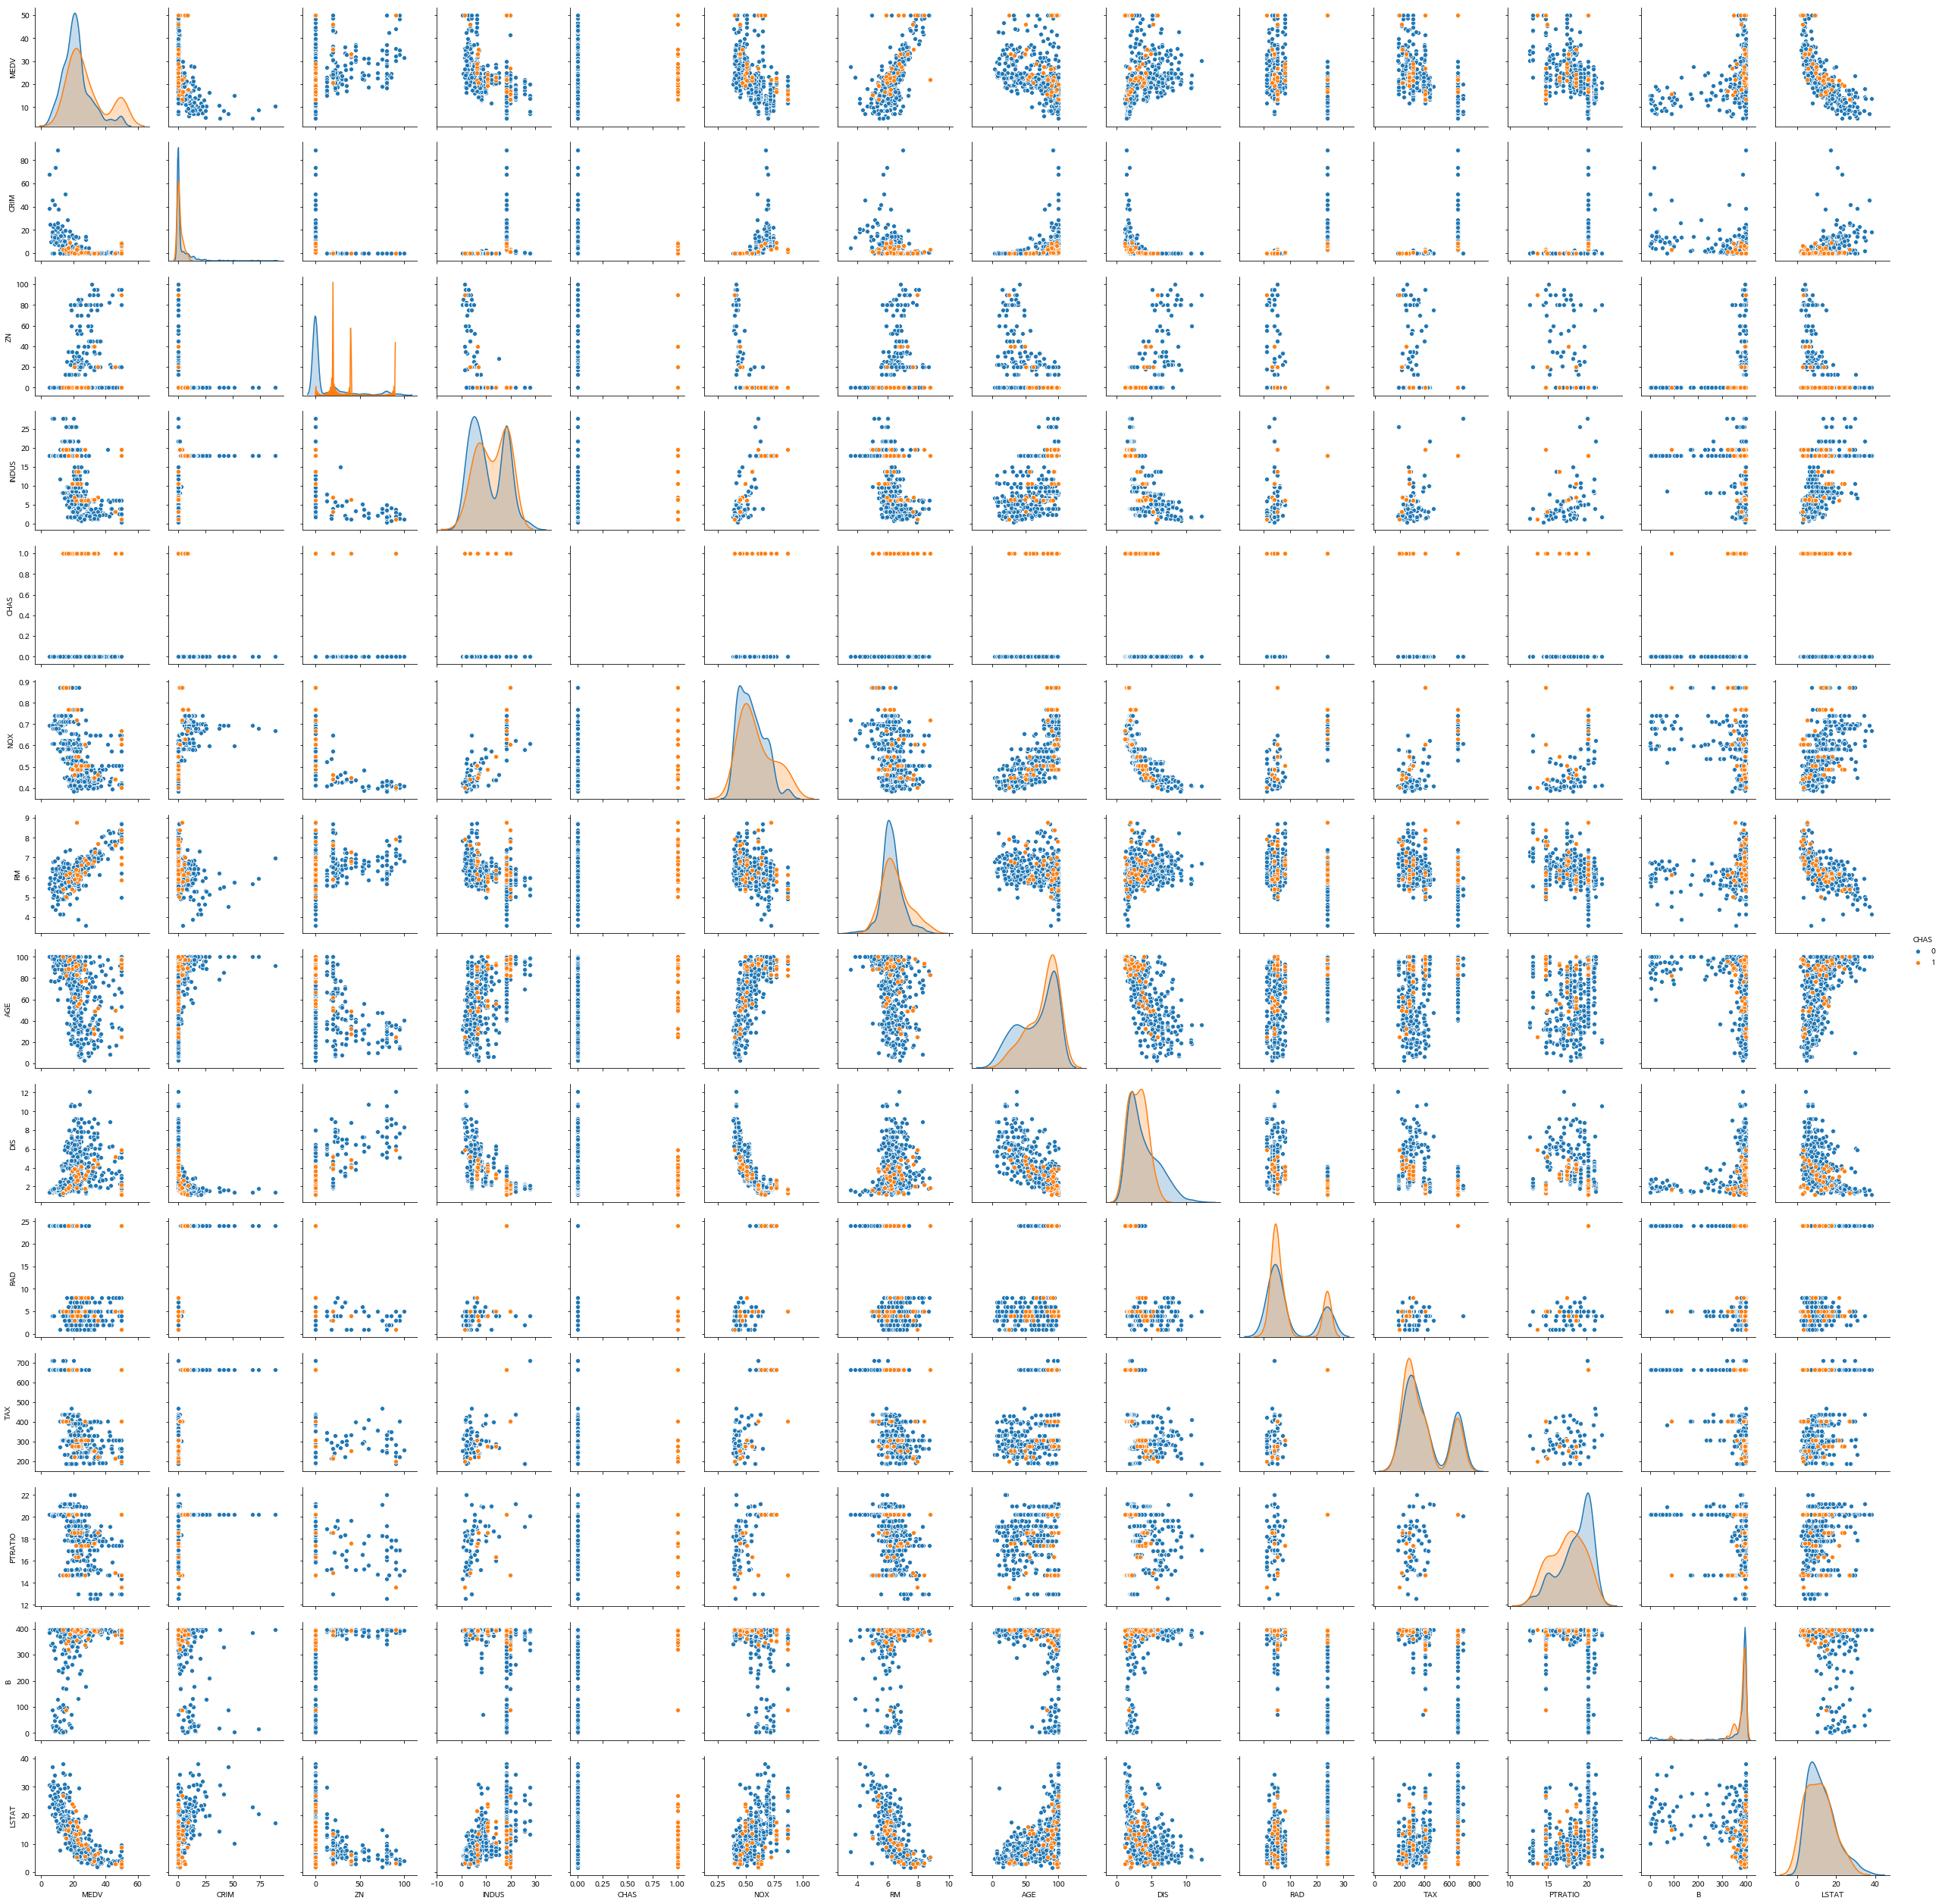

In [113]:
sns.pairplot(ds_bo,hue="CHAS")
#CHAS강의 경우 1일 경우 그래프 분포가 다름
#특정 집값 구간에서 절단 현상이 일어나며, 다른 그룹의 형태
#일반적으로 비싼 집의 경우 CHAS일 확률이 큼

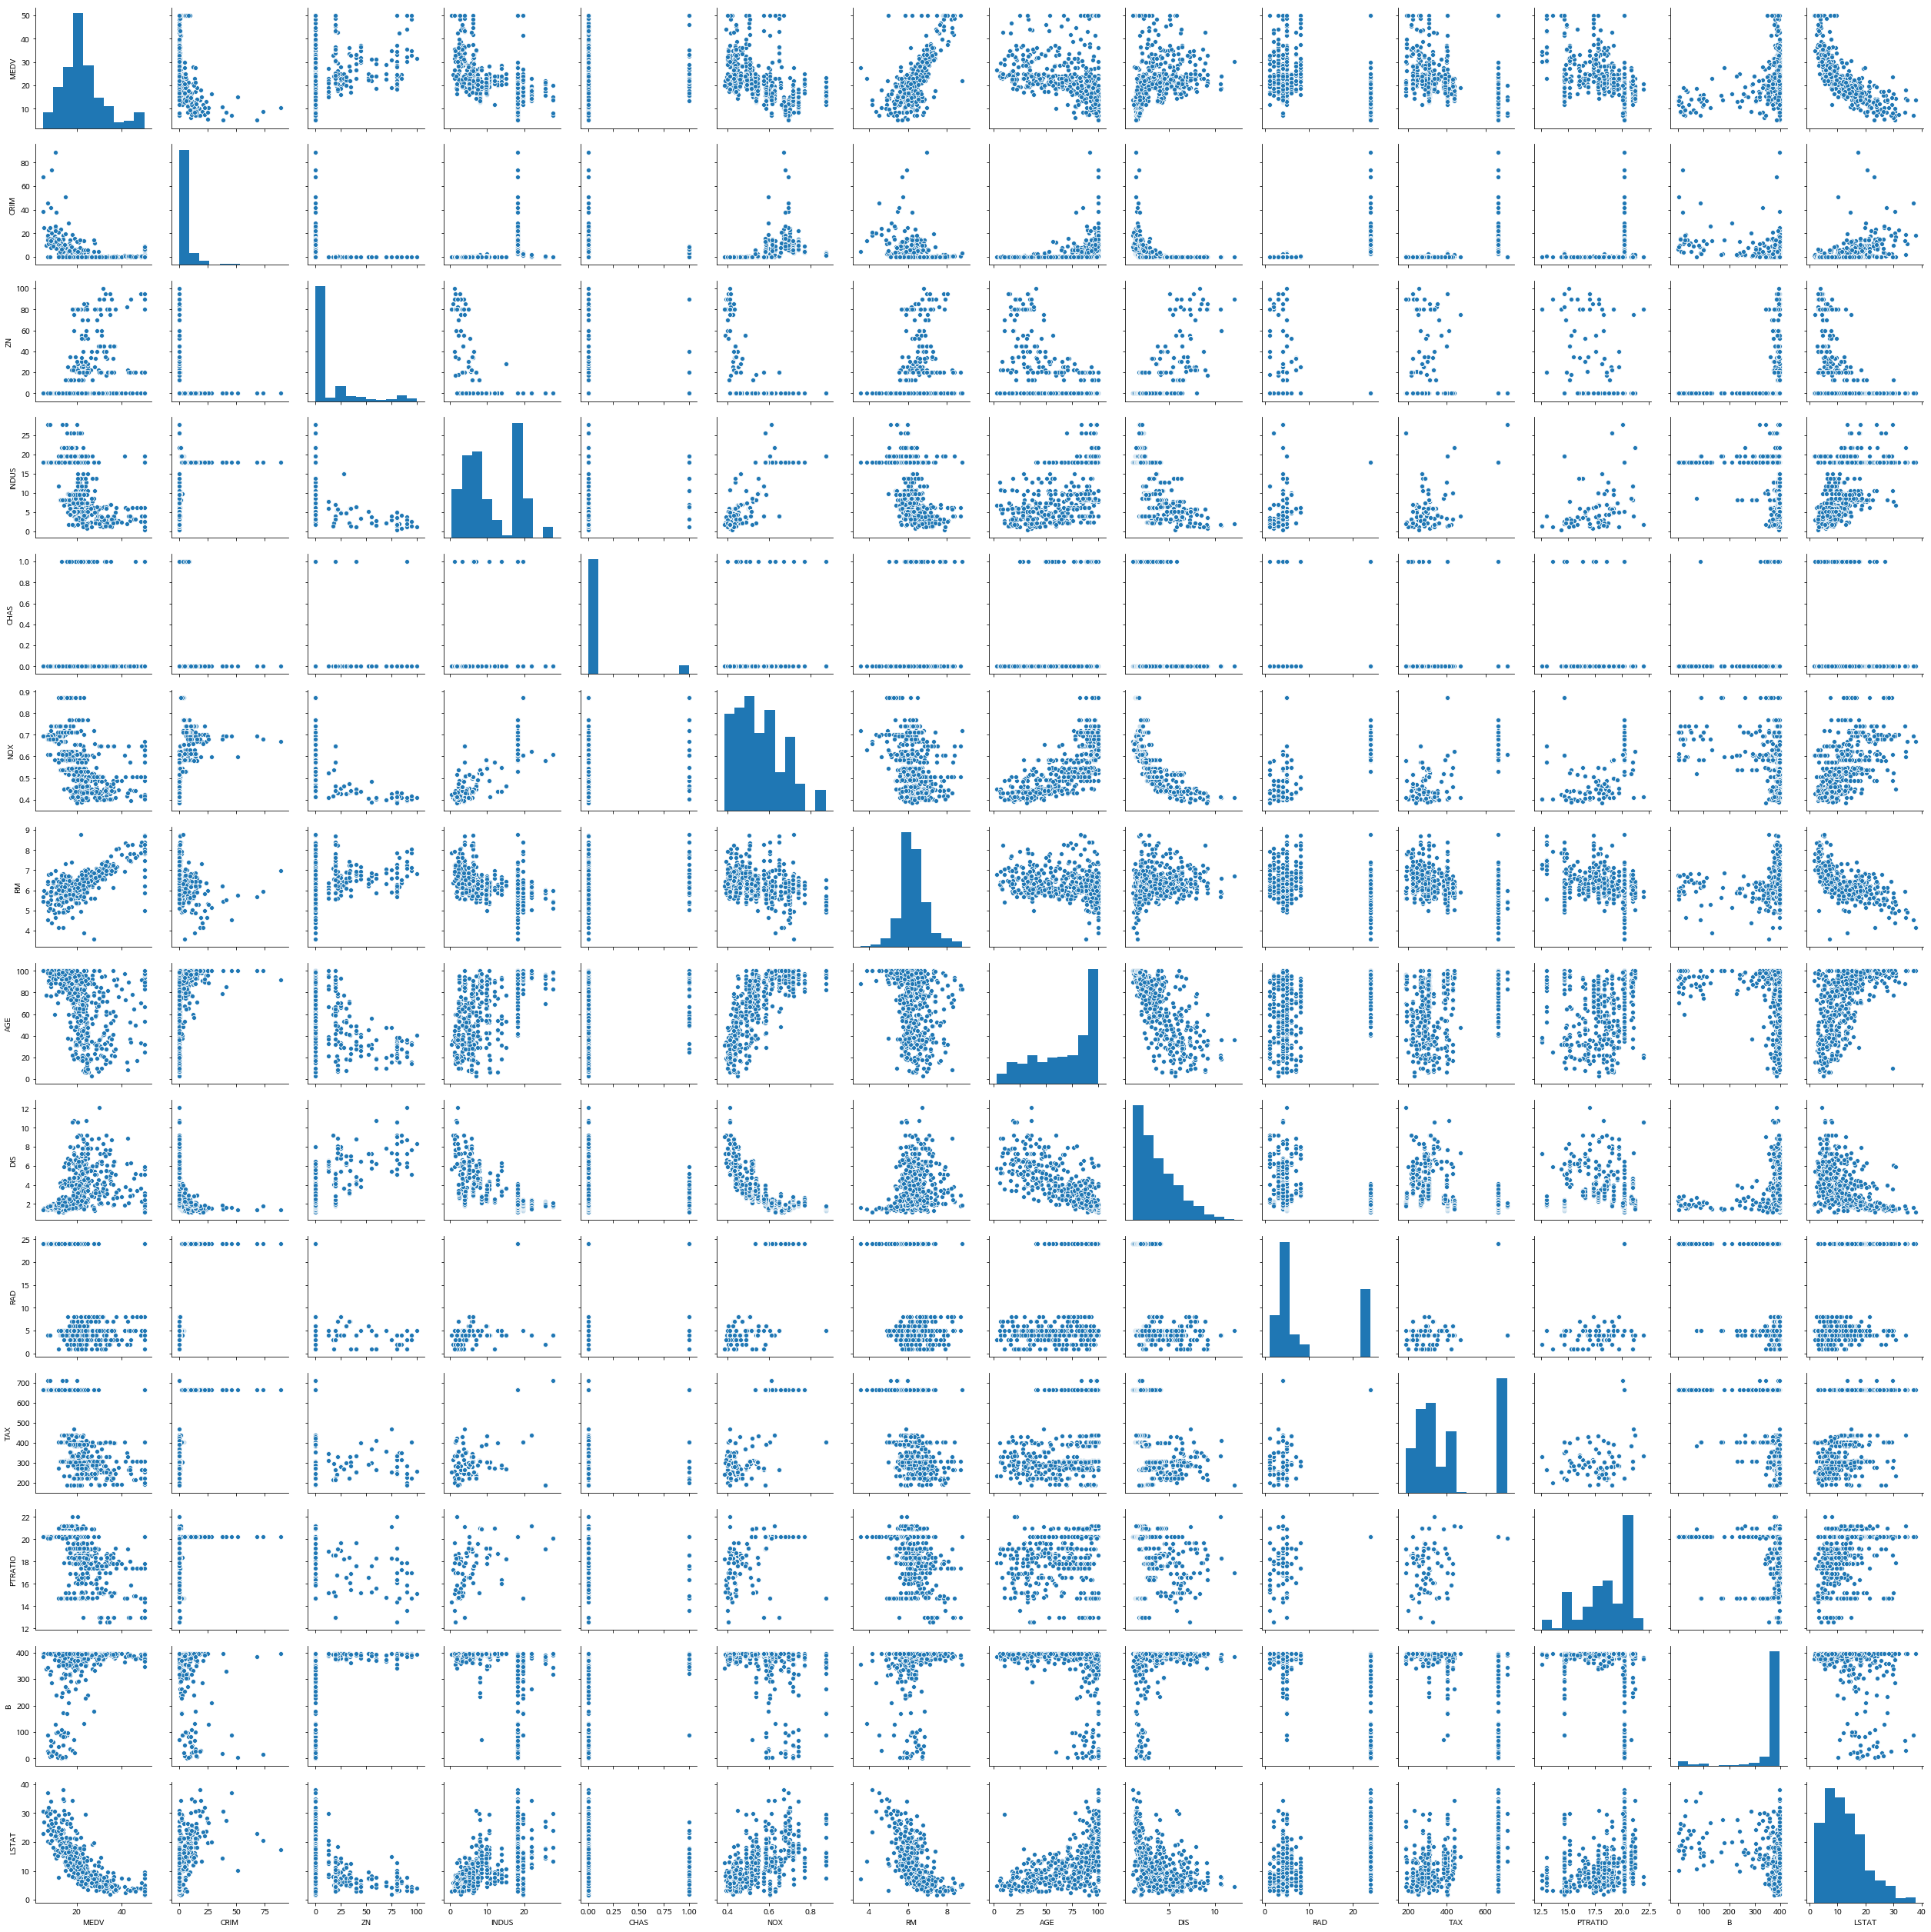

In [114]:
sns.pairplot(ds_bo)
#LSTAT과 MEDV는 음의 상관관계
#PTRATIO와 MEDV는 음의 상관관계 : 상식적이지 않음, 학생당 교사가 많을수록 가격이 더 싸다?
#미국 보스턴 교육, 교사비율 검토 필요
#RM과 MEDV는 강한 양의 상관관계
#INDUS 공업지역 비율은 MEDV와 음의 상관관계
#NOX가 음의 상관관계 // 구간 주의


In [115]:
ds_bo.corr().round(3)
#집값은 범죄율, 공업지비율, 산화질소, 노후건물비율, 고속도로접근성, 재산세율, 학생당교사비율, 저소득층비율이 낮을수록 높다고 나옴
#일부 변수는 상식선에서 이해가 가나, 고속도로접근성, 재산세율, 학생당 교사비율의 경우 검토 필요

#주거지비율,강변여부,주거당평균객실수,중심지접근거리,흑인비율이 높을수록 집값이 높다
#중심지접근거리, 흑인비율의 변수 면밀 검토 필요

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
MEDV,1.000,-0.388,0.360,-0.484,0.175,-0.427,0.695,-0.377,0.250,-0.382,-0.469,-0.508,0.333,-0.738
CRIM,-0.388,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456
ZN,0.360,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413
INDUS,-0.484,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604
CHAS,0.175,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054
NOX,-0.427,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591
RM,0.695,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614
AGE,-0.377,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602
DIS,0.250,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497
RAD,-0.382,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489


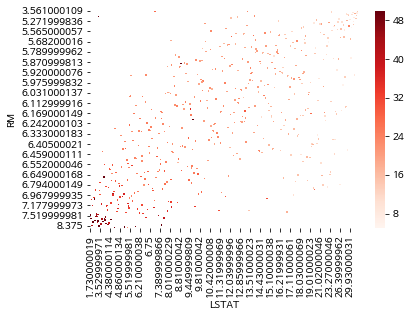

In [11]:
ds_agg=ds_bo.groupby(["RM","LSTAT"],as_index=False).agg("mean")
ds_pivot=ds_agg.pivot("RM","LSTAT","MEDV")
sns.heatmap(ds_pivot,cmap="Reds")

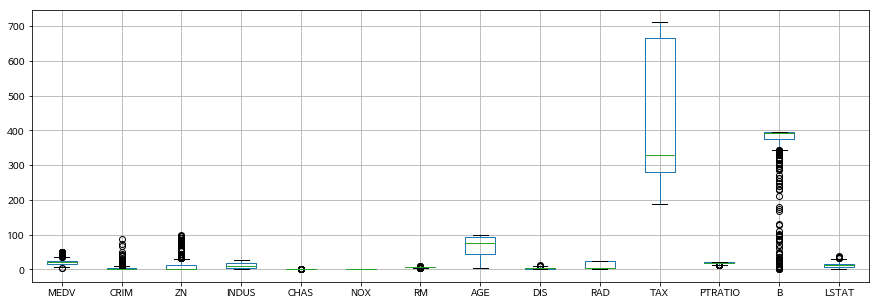

In [116]:
ds_bo.boxplot(figsize=(15,5))
#B를 이상치 처리하기 애매
#실측 집값 data를 이상치 처리하기 어려움
#scale차이가 나서 변수별 따로 boxplot

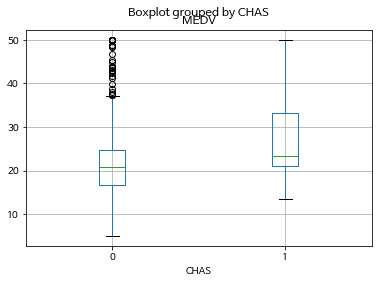

In [22]:
ds_bo.boxplot(column="MEDV", by="CHAS")
#CHAS여부에 따라 집값 중앙값이 다르지만
#강 근처가 아니여도 비싼 집이 많음 <<

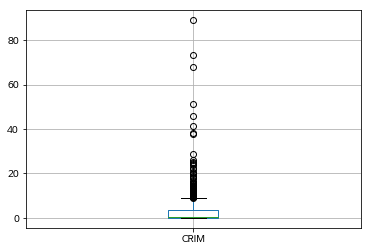

In [119]:
ds_bo.boxplot(column="CRIM")

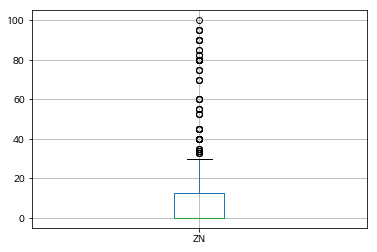

In [120]:
ds_bo.boxplot(column="ZN")

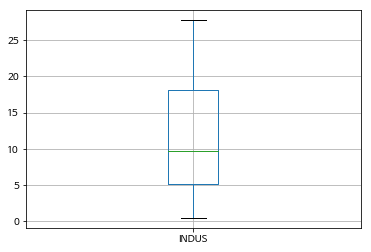

In [121]:
ds_bo.boxplot(column="INDUS")

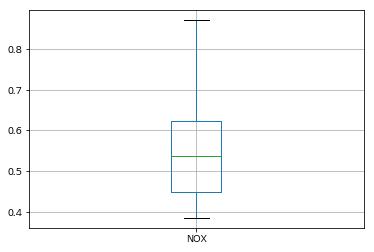

In [123]:
ds_bo.boxplot(column="NOX")

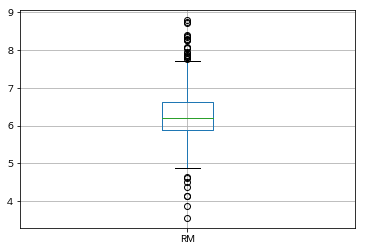

In [124]:
ds_bo.boxplot(column="RM")

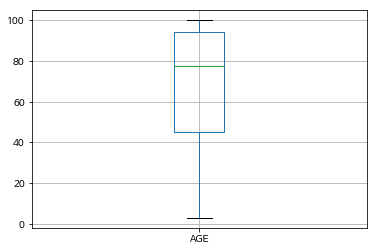

In [125]:
ds_bo.boxplot(column="AGE")

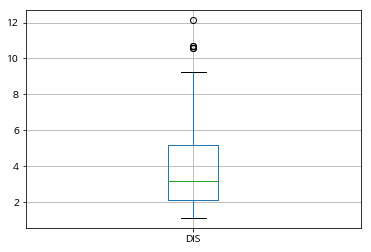

In [126]:
ds_bo.boxplot(column="DIS")

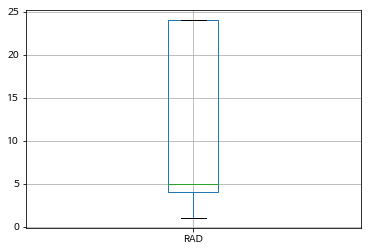

In [127]:
ds_bo.boxplot(column="RAD")

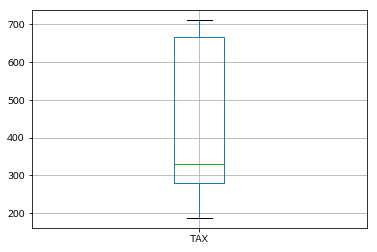

In [128]:
ds_bo.boxplot(column="TAX")

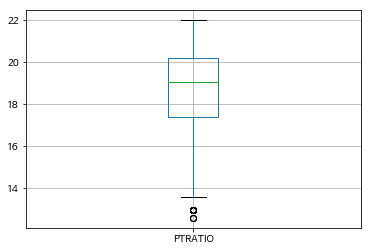

In [129]:
ds_bo.boxplot(column="PTRATIO")

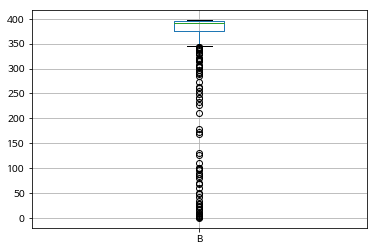

In [131]:
ds_bo.boxplot(column="B")

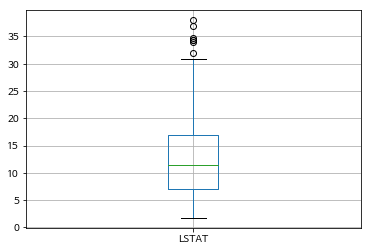

In [130]:
ds_bo.boxplot(column="LSTAT")

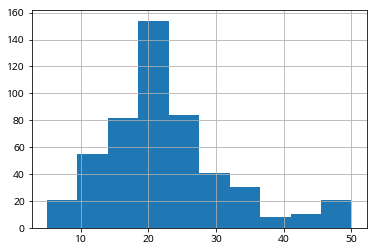

In [24]:
ds_bo["MEDV"].hist()
#어느 정도 정규성을 띄나, 일부 고가층의 data가 형성

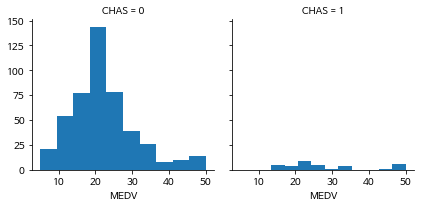

In [37]:
grid=sns.FacetGrid(ds_bo, col="CHAS")
grid.map(plt.hist,"MEDV")
#대부분의 데이터가 CHAS=0의 데이터
#CHAS=1에도 집값이 낮은 곳도 존재하나, 비율상 고가일 확률이 높음

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3703834cc0>,
      dtype=object)

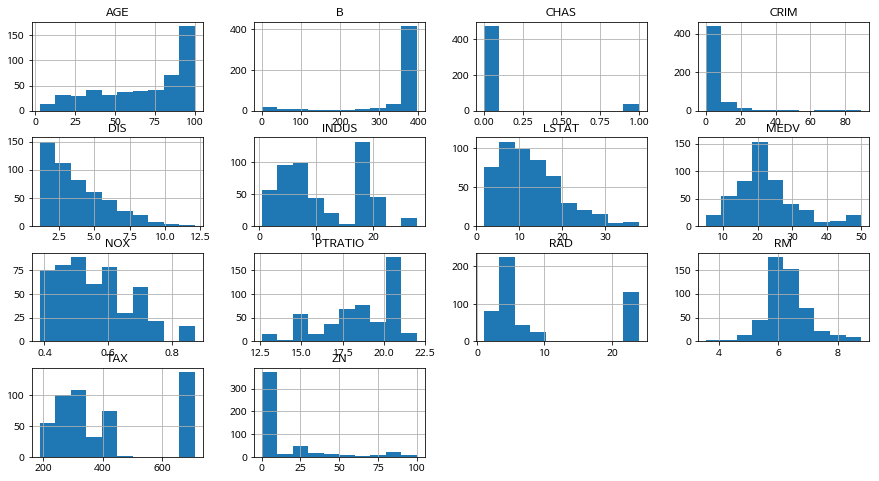

In [35]:
ds_bo.hist(figsize=(15,8))
#AGE 노후건물비율이 높은 data가 많으며
#B 흑인비율이 높은 data가 많으며
#CHAS 강이 안 보이는 곳의 data가 더 많으며
#CRIM 범죄율이 낮은 data가 더 많으며
#DIS 중심지와의 거리가 가까운 곳의 data가 많으며
#INDUS 공업지비율은 0~10의 낮은 곳과 20근처의 적당 수준이 그룹화돼있고
#LSTAT 저소득층비율이 20미만의 낮은 곳의 data가 많으며


#NOX 0.4~0.6에 많이 분포하며 0.7 부근에도 일부 data층 분포
#PTRATIO 학생당 교사비율은 15~21에서 비교적 고르나 20 부근이 압도적으로 많음
#RAD 고속도로편이성지수는 0~10에서 4부근이 가장 많으며 20 이상의 데이터섬 존재
#RM 주거당평균객실수 5~7에 대부분 분포하며 6이 가장 많음
#TAX 200~400에 대부분 분포하나 일부 600이상 데이터섬 존재
#ZN 주거지비율 매우 낮은 값(=0)에서 최빈값 발생 그 외 100까지 고르게 분포 -> 0에 대한 해석 필요


In [38]:
ds_bo_x_const=sm.add_constant(ds_bo_x)
ds_bo_x_const.head()

,const,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [42]:
#회귀 모델 생성
reg_multi_model=sm.OLS(ds_bo_y,ds_bo_x_const)
#적합
reg_multi_results=reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          6.72e-135
Time:                        11:41:45   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

In [55]:
ds_vif=pd.DataFrame()
ds_vif["variable"]=ds_bo_x_const.columns
ds_vif["VIF"]=[variance_inflation_factor(ds_bo_x_const.values,i) for i in range(ds_bo_x_const.shape[1])]
ds_vif.sort_values("VIF",inplace=True)
ds_vif.round(3)

,variable,VIF
4,CHAS,1.074
12,B,1.349
1,CRIM,1.792
11,PTRATIO,1.799
6,RM,1.934
2,ZN,2.299
13,LSTAT,2.941
7,AGE,3.101
8,DIS,3.956
3,INDUS,3.992


In [136]:
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=8).fit(ds_bo_x,ds_bo_y)
selected_cols=ds_bo_x.columns[rfe.support_]
removed_cols=ds_bo_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))

Selected Variables:Index(['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO', 'LSTAT'], dtype='object')
Removed Variables:Index(['ZN', 'INDUS', 'AGE', 'TAX', 'B'], dtype='object')


In [137]:
ds_bo_x_rfe=sm.add_constant(ds_bo_x_const[selected_cols])
reg_multi_rfe_model=sm.OLS(ds_bo_y,ds_bo_x_rfe)
reg_multi_rfe_results=reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     162.4
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          2.26e-133
Time:                        14:30:10   Log-Likelihood:                -1515.2
No. Observations:                 506   AIC:                             3048.
Df Residuals:                     497   BIC:                             3086.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.8089      4.967      8.216      0.0

In [56]:
ds_rfe_vifd=pd.DataFrame()
ds_rfe_vifd["variable"]=ds_bo_x_rfe.columns
ds_rfe_vifd["VIF"]=[variance_inflation_factor(ds_bo_x_rfe.values,i) for i in range(ds_bo_x_rfe.shape[1])]
ds_rfe_vifd.sort_values("VIF",inplace=True)
ds_rfe_vifd.round(3)
#다중공선성이 모두 4 이하로 매우 낮음

,variable,VIF
2,CHAS,1.049
7,PTRATIO,1.537
1,CRIM,1.750
4,RM,1.765
8,LSTAT,2.523
5,DIS,2.579
6,RAD,2.656
3,NOX,3.525
0,const,524.788


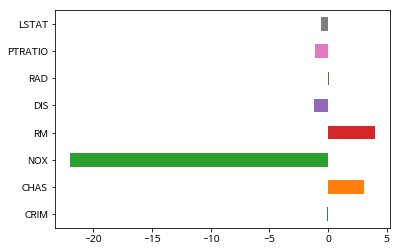

In [57]:
ds_reg_coef=pd.DataFrame({"Coef":reg_multi_rfe_results.params.values[1:]}, index=reg_multi_rfe_model.exog_names[1:])
ds_reg_coef.plot.barh(y="Coef", legend=False)
#표준화 이전

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


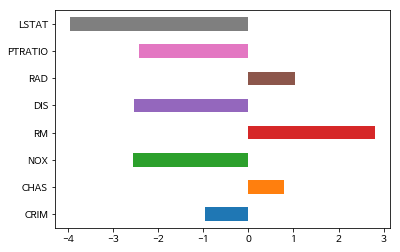

In [59]:
ds_bo_x_scaled=scale(ds_bo_x_const[selected_cols])
ds_bo_x_scaled=sm.add_constant(ds_bo_x_scaled)
reg_multi_scaled_model=sm.OLS(ds_bo_y,ds_bo_x_scaled)
reg_multi_scaled_results=reg_multi_scaled_model.fit()
ds_reg_scale_coef=pd.DataFrame({"Coef":reg_multi_scaled_results.params.values[1:]},
                               index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scale_coef.plot.barh(y="Coef",legend=False)

In [60]:
reg_multi_scaled_results.params

const    22.532806
x1       -0.950509
x2        0.785193
x3       -2.541592
x4        2.800822
x5       -2.523604
x6        1.033183
x7       -2.412482
x8       -3.938033
dtype: float64

In [93]:
a = ds_bo_x_rfe.iloc[:,1:]
# const 삭제

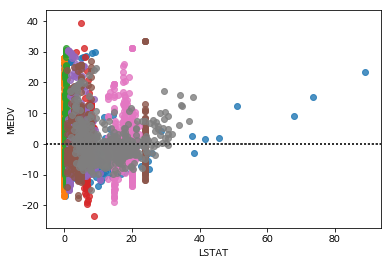

In [94]:
for i in list(a.columns):
    sns.residplot(ds_bo[i],ds_y)
#잔차 산점도

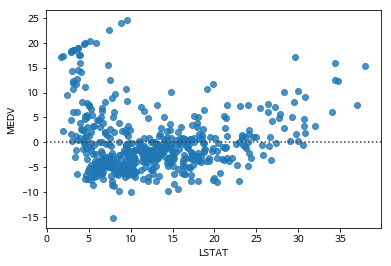

In [79]:
ds_bo_CR=ds_bo["CRIM"]
ds_bo_CH=ds_bo["CHAS"]
ds_bo_NO=ds_bo["NOX"]
ds_bo_RM=ds_bo["RM"]
ds_bo_DIS=ds_bo["DIS"]
ds_bo_RAD=ds_bo["RAD"]
ds_bo_PTRATIO=ds_bo["PTRATIO"]
ds_bo_LASTAT=ds_bo["LSTAT"]
sns.residplot(ds_bo_CR,ds_y)

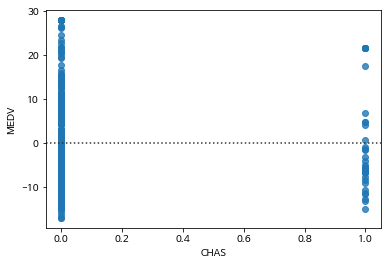

In [95]:
sns.residplot(ds_bo_CH,ds_y)

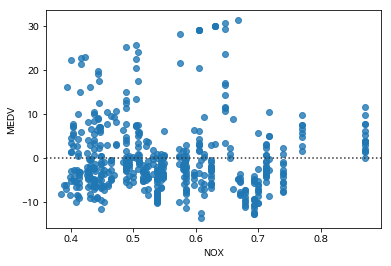

In [96]:
sns.residplot(ds_bo_NO,ds_y)

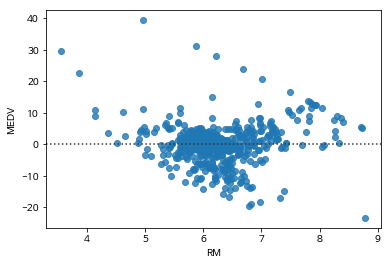

In [97]:
sns.residplot(ds_bo_RM,ds_y)

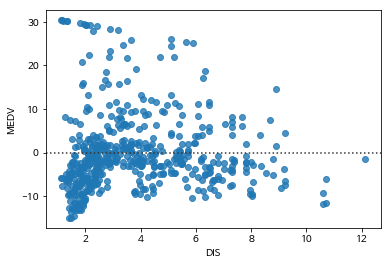

In [98]:
sns.residplot(ds_bo_DIS,ds_y)

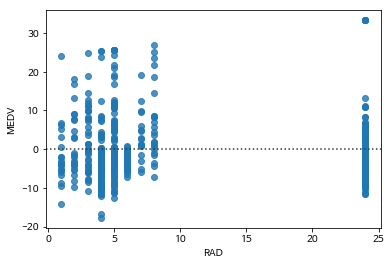

In [99]:
sns.residplot(ds_bo_RAD,ds_y)

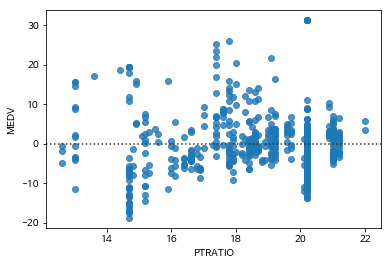

In [100]:
sns.residplot(ds_bo_PTRATIO,ds_y)

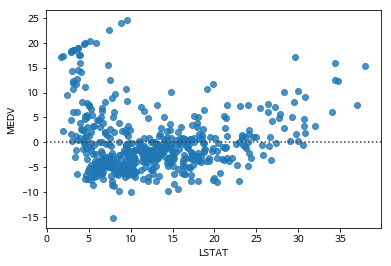

In [101]:
sns.residplot(ds_bo_LASTAT,ds_y)

((array([-2.99573567e+00, -2.71411028e+00, -2.55577619e+00, -2.44351800e+00,
         -2.35556494e+00, -2.28276382e+00, -2.22036495e+00, -2.16557440e+00,
         -2.11660431e+00, -2.07223893e+00, -2.03161265e+00, -1.99408648e+00,
         -1.95917475e+00, -1.92649942e+00, -1.89576017e+00, -1.86671438e+00,
         -1.83916307e+00, -1.81294098e+00, -1.78790928e+00, -1.76395019e+00,
         -1.74096288e+00, -1.71886034e+00, -1.69756695e+00, -1.67701655e+00,
         -1.65715093e+00, -1.63791855e+00, -1.61927361e+00, -1.60117517e+00,
         -1.58358651e+00, -1.56647453e+00, -1.54980933e+00, -1.53356377e+00,
         -1.51771316e+00, -1.50223493e+00, -1.48710847e+00, -1.47231481e+00,
         -1.45783653e+00, -1.44365756e+00, -1.42976302e+00, -1.41613915e+00,
         -1.40277318e+00, -1.38965322e+00, -1.37676820e+00, -1.36410778e+00,
         -1.35166231e+00, -1.33942275e+00, -1.32738062e+00, -1.31552796e+00,
         -1.30385728e+00, -1.29236155e+00, -1.28103411e+00, -1.26986869e+00,

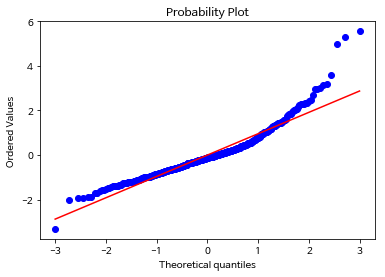

In [63]:
res=reg_multi_rfe_results.resid
z=(res-np.mean(res))/np.std(res)
stats.probplot(z, dist="norm", plot=plt)
#일부 정규성을 벗어나는 data가 있으나 대체로 정규성을 만족한다고 볼 수 있음